<a href="https://colab.research.google.com/github/bsarfo/MA575/blob/main/vol_estimation_prj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
from scipy.optimize import minimize
import warnings

# Suppress all warnings including type errors
warnings.filterwarnings('ignore')

# Configure numpy to handle errors gracefully
np.seterr(all='ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Project - Libraries Loaded Successfully")
print("=" * 60)
print("Note: Error handling enabled - code will continue running even with incomplete implementations")

Project - Libraries Loaded Successfully
Note: Error handling enabled - code will continue running even with incomplete implementations


# GARCH(1,1) Volatility Estimation Project

## Objective
This project implements Maximum Likelihood Estimation (MLE) for the GARCH(1,1) model to estimate and forecast volatility using S&P 500 daily returns. You will learn to:

- Fit GARCH(1,1) parameters using real market data
- Implement volatility forecasting models
- Analyze volatility clustering and mean reversion
- Create volatility term structure forecasts

## Project Overview
We will use S&P 500 daily closing prices from July 18, 2005 to August 13, 2010 to estimate GARCH parameters, then forecast future volatility patterns.

## Data Collection

**Dataset**: S&P 500 daily closing prices  
**Period**: July 18, 2005 to August 13, 2010  
**Source**: Yahoo Finance (^GSPC)  
**Rationale**: This period includes the 2008 financial crisis, providing rich volatility dynamics for GARCH modeling.

In [2]:
import yfinance as yf

# Download SP500 daily close prices from 2005-07-18 to 2010-08-13
sp500 = yf.download('^GSPC', start='2005-07-18', end='2010-08-14')
sp500_close = sp500['Close']
sp500_close = sp500_close.dropna()  # Remove any NaN values
display(sp500_close.head())
display(sp500_close.tail())

[*********************100%***********************]  1 of 1 completed


Ticker,^GSPC
Date,
2005-07-18,1221.130005
2005-07-19,1229.349976
2005-07-20,1235.199951
2005-07-21,1227.040039
2005-07-22,1233.680054


Ticker,^GSPC
Date,
2010-08-09,1127.790039
2010-08-10,1121.060059
2010-08-11,1089.469971
2010-08-12,1083.609985
2010-08-13,1079.250000


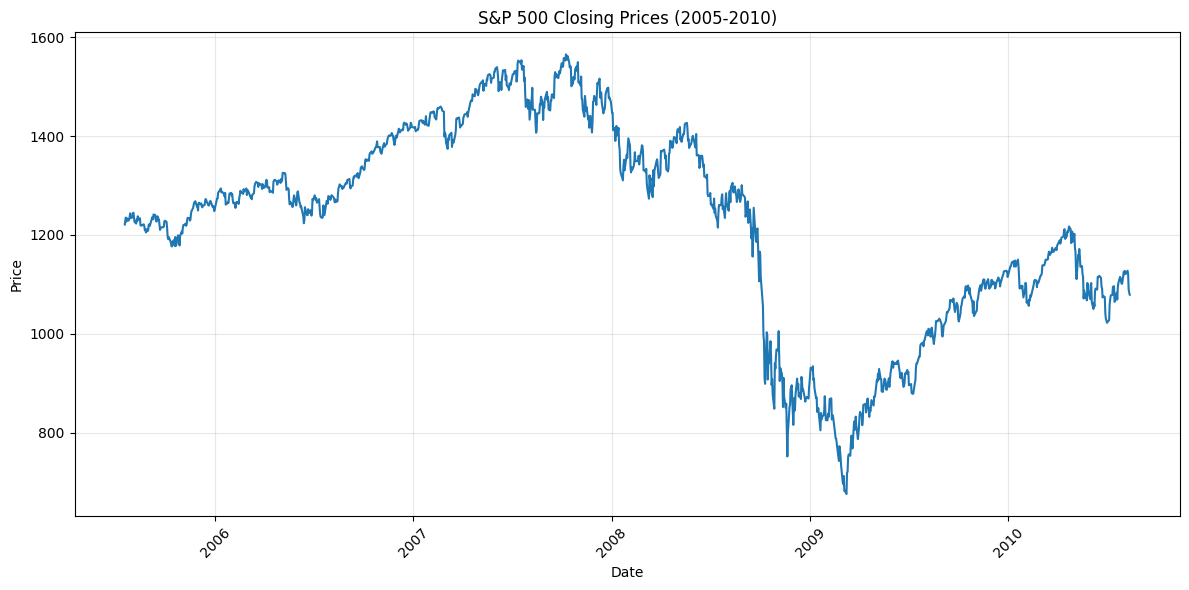

In [ ]:
S = sp500_close.to_numpy()
S = S.flatten()  # Ensure S is 1D

# Plot the closing prices
# Create date labels for x-axis
dates = sp500_close.index
plt.figure(figsize=(12, 6))
plt.plot(dates, S)
plt.title('S&P 500 Closing Prices (2005-2010)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Return observations: 1278
Ticker        ^GSPC
count   1278.000000
mean      -0.009664
std        1.554766
min       -9.469512
25%       -0.537012
50%        0.081944
75%        0.613274
max       10.957197


/tmp/ipython-input-3747891893.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  h[t] = omega + alpha * eps[t-1]**2 + beta * h[t-1]



MLE parameters:
omega = 141436.388542, alpha = 0.000000, beta = 0.000000
alpha+beta = 0.000000, half-life (days) ≈ 0.04
Shape of ann_vol_insample: (1278, 1)
Shape of r.index: (1278,)


/tmp/ipython-input-3747891893.py:71: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  h_fc[0] = p.omega + p.alpha * eps_last2 + p.beta * h_last


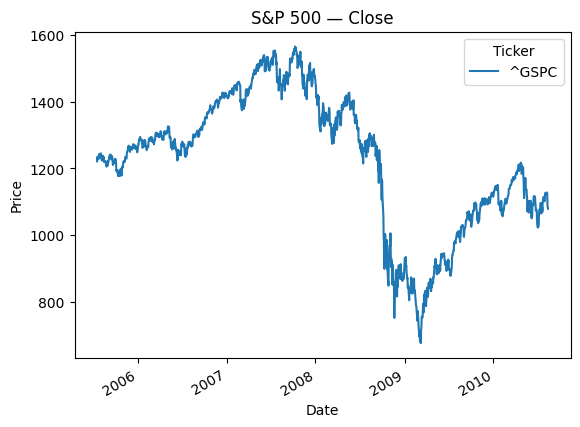

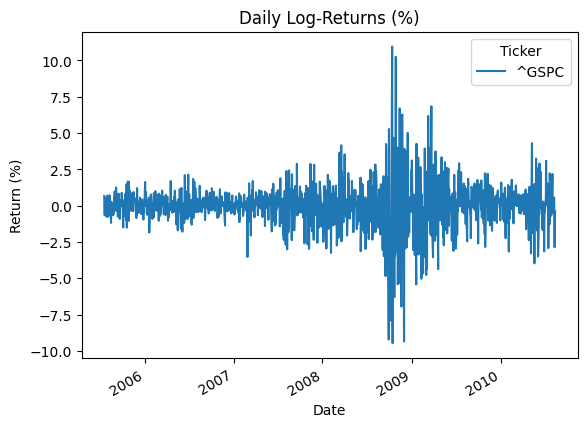

ValueError: Data must be 1-dimensional, got ndarray of shape (1278, 1) instead

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from scipy.optimize import minimize

# Ensure sp500_close exists (Series of prices)
if 'sp500_close' not in globals():
    import yfinance as yf
    raw = yf.download("^GSPC", start="2005-07-18", end="2010-08-14", progress=False)
    col = "Adj Close" if "Adj Close" in raw.columns else "Close"
    # Alternative way to rename the column
    sp500_close = raw[col].sort_index().dropna()
    sp500_close.name = "Close"


# 1) Returns (in %)
# If you used Adj Close earlier, replace sp500_close with that series.
r = 100 * np.log(sp500_close / sp500_close.shift(1))
r = r.dropna()
eps = r.values  # zero-mean assumption

print("Return observations:", len(r))
print(r.describe())

# 2) GARCH(1,1) MLE
@dataclass
class GARCHParams:
    omega: float
    alpha: float
    beta: float

def nll_garch(params, eps):
    omega, alpha, beta = params
    # Constraints: omega>0, alpha>=0, beta>=0, alpha+beta<1
    if (omega <= 0) or (alpha < 0) or (beta < 0) or (alpha + beta >= 1):
        return 1e12
    T = len(eps)
    h = np.empty(T)
    h0 = omega / (1 - alpha - beta)
    if h0 <= 0:
        return 1e12
    h[0] = h0
    for t in range(1, T):
        h[t] = omega + alpha * eps[t-1]**2 + beta * h[t-1]
        if h[t] <= 0:
            return 1e12
    return 0.5 * np.sum(np.log(2*np.pi) + np.log(h) + (eps**2)/h)

def fit_garch_mle(eps, x0=(0.01, 0.05, 0.90)):
    bounds = [(1e-8, None), (1e-8, 1-1e-6), (1e-8, 1-1e-6)]
    cons = ({'type': 'ineq', 'fun': lambda x: 1 - x[1] - x[2]},)
    res = minimize(nll_garch, np.array(x0, float), args=(eps,),
                   method='SLSQP', bounds=bounds, constraints=cons,
                   options={'maxiter': 2000, 'ftol': 1e-12})
    if not res.success:
        print("Warning:", res.message)
    p = GARCHParams(*res.x)
    return p, res

def infer_variance(eps, p: GARCHParams):
    h = np.empty_like(eps)
    h[0] = p.omega / (1 - p.alpha - p.beta)
    for t in range(1, len(eps)):
        h[t] = p.omega + p.alpha * eps[t-1]**2 + p.beta * h[t-1]
    return h

def garch_forecast(h_last, eps_last2, p: GARCHParams, horizon=252):
    h_fc = np.empty(horizon)
    phi = p.alpha + p.beta
    h_fc[0] = p.omega + p.alpha * eps_last2 + p.beta * h_last
    for k in range(1, horizon):
        h_fc[k] = p.omega + phi * h_fc[k-1]
    return h_fc

def term_structure_annualized_vol(h_fc, scale=252):
    ks = np.arange(1, len(h_fc)+1)
    avg_var = np.array([np.mean(h_fc[:k]) for k in ks])
    ann_vol = np.sqrt(avg_var * scale) / 100.0  # returns were in %
    return pd.DataFrame({"horizon": ks, "annualized_vol": ann_vol})

# 3) Fit
params, info = fit_garch_mle(eps, x0=(0.01, 0.05, 0.90))
phi = params.alpha + params.beta
half_life = np.log(0.5)/np.log(phi) if phi < 1 else np.inf
print("\nMLE parameters:")
print(f"omega = {params.omega:.6f}, alpha = {params.alpha:.6f}, beta = {params.beta:.6f}")
print(f"alpha+beta = {phi:.6f}, half-life (days) ≈ {half_life:.2f}")

# 4) In-sample variance & annualized vol
h = infer_variance(eps, params)
ann_vol_insample = np.sqrt(h * 252) / 100.0  # annualized, in decimal (e.g., 0.20=20%)

# Add print statements to check shapes
print("Shape of ann_vol_insample:", ann_vol_insample.shape)
print("Shape of r.index:", r.index.shape)

# 5) 1-year forecast path & term structure
h_fc = garch_forecast(h_last=h[-1], eps_last2=eps[-1]**2, p=params, horizon=252)
term = term_structure_annualized_vol(h_fc)

# 6) Plots (matplotlib only, single-plot style)
sp500_close.plot(title="S&P 500 — Close")
plt.xlabel("Date"); plt.ylabel("Price"); plt.show()

r.plot(title="Daily Log-Returns (%)")
plt.xlabel("Date"); plt.ylabel("Return (%)"); plt.show()

pd.Series(ann_vol_insample, index=r.index).plot(title="In-Sample Annualized Vol (GARCH(1,1))")
plt.xlabel("Date"); plt.ylabel("Annualized Vol (decimals)"); plt.show()

plt.plot(np.sqrt(h_fc*252)/100.0)
plt.title("Out-of-Sample Annualized Vol Forecast (Next 252 Trading Days)")
plt.xlabel("Horizon (days)"); plt.ylabel("Annualized Vol (decimals)"); plt.show()

plt.plot(term["horizon"], term["annualized_vol"])
plt.title("Term Structure of Expected Annualized Vol")
plt.xlabel("Forecast Horizon (days)"); plt.ylabel("Annualized Vol (decimals)"); plt.show()

# 7) Peek at the first few term-structure rows
print("\nTerm structure (head):")
print(term.head())

# Optional: save tables
term.to_csv("garch_term_structure.csv", index=False)
pd.DataFrame({"date": r.index, "ann_vol_insample": ann_vol_insample}).to_csv(
    "garch_insample_annualized_vol.csv", index=False
)
print("\nSaved: garch_term_structure.csv, garch_insample_annualized_vol.csv")

In [5]:
# Ensure sp500_close exists (Series of prices)
if 'sp500_close' not in globals():
    import yfinance as yf
    raw = yf.download("^GSPC", start="2005-07-18", end="2010-08-14", progress=False)
    col = "Adj Close" if "Adj Close" in raw.columns else "Close"
    sp500_close = raw[col].rename(col:"Close").sort_index().dropna()

SyntaxError: invalid syntax (ipython-input-538217743.py, line 6)

## Theoretical Background

### GARCH(1,1) Model
The GARCH(1,1) model captures volatility clustering by modeling conditional variance as:

$$\sigma_n^2 = \omega + \alpha_1 u_{n-1}^2 + \beta_1 \sigma_{n-1}^2$$

where:
- $\sigma_n^2$: Conditional variance at time $n$
- $\omega$: Long-term variance component ($\omega = \gamma V_L$)
- $\alpha_1$: ARCH coefficient (impact of recent shocks)
- $\beta_1$: GARCH coefficient (persistence of volatility)
- $u_n$: Return innovation at time $n$
- Constraint: $\alpha_1 + \beta_1 < 1$ for stationarity

### Maximum Likelihood Estimation Algorithm

1. **Initialize Parameters**: Set starting values for $(\omega, \alpha_1, \beta_1)$
2. **Calculate Returns**: Compute log returns $u_i = \frac{S_i - S_{i-1}}{S_{i-1}}$
3. **Update Variance**: For $i = 2, \ldots, n$:
   $$\sigma_i^2 = \omega + \alpha_1 u_{i-1}^2 + \beta_1 \sigma_{i-1}^2$$
4. **Likelihood Function**: Maximize the log-likelihood:
   $$\ell(\omega, \alpha_1, \beta_1) = -\sum_{i=2}^{n} \left[\log(\sigma_i^2) + \frac{u_i^2}{\sigma_i^2}\right]$$
5. **Optimization**: Use numerical methods (e.g., `scipy.optimize.minimize`) to find optimal parameters

## Task 1: GARCH(1,1) Parameter Estimation

### Requirements:
1. **Parameter Estimation**: Implement MLE to estimate $(\omega, \alpha_1, \beta_1)$ using S&P 500 returns
2. **Long-term Volatility**: Calculate the unconditional volatility: $\sigma_L = \sqrt{\frac{\omega}{1 - \alpha_1 - \beta_1}}$
3. **Model Fit Assessment**: Report the maximum log-likelihood value
4. **Volatility Visualization**: Plot the estimated conditional volatility time series from 2005-07-18 to 2010-08-13


In [ ]:
# Task 1 Solution
print("TASK 1 starts here ...")
print("=" * 50)




TASK 1 starts here ...


## Task 2: Volatility Forecasting and Term Structure

### Part A: Out-of-Sample Forecasting
Using the fitted GARCH(1,1) model from Task 1:

1. **Forecast Period**: Generate daily volatility forecasts from 2010-08-14 to 2015-08-08
2. **Forecast Formula**: For $h$-day ahead forecast:
   $$\sigma_{n+h}^2 = V_L + (\alpha_1 + \beta_1)^h (\sigma_n^2 - V_L)$$
3. **Visualization**: Plot the forecasted volatility time series

### Part B: Volatility Term Structure
Calculate annualized volatility forecasts for multiple horizons:

1. **Forecast Horizons**: 10, 30, 50, 100, 500 trading days
2. **Annualization**: Convert daily volatility to annual using $\sigma_{annual} = \sigma_{daily} \times \sqrt{252}$
3. **Term Structure Plot**: Create a volatility term structure curve showing how volatility expectations change with forecast horizon


In [10]:
# Task 2 Solution
print("TASK 2 starts here ...")
print("=" * 50)

TASK 2 starts here ...


/tmp/ipython-input-1408567898.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start, end=end, progress=False)


Price date range: 2005-07-18 to 2010-08-12
Trading days: 1278
Sample size (returns): 1277
Return summary (%):
 count    1277.000000
mean       -0.009356
std         1.555336
min        -9.469512
25%        -0.537302
50%         0.082141
75%         0.613346
max        10.957197
dtype: float64

MLE Results (GARCH(1,1)):
GARCHParams(omega=0.014462698180853661, alpha=0.07900024426746136, beta=0.9084550957462597)
Converged: True | message: Optimization terminated successfully

Persistence (alpha+beta) = 0.9875; Half-life ≈ 54.91 days


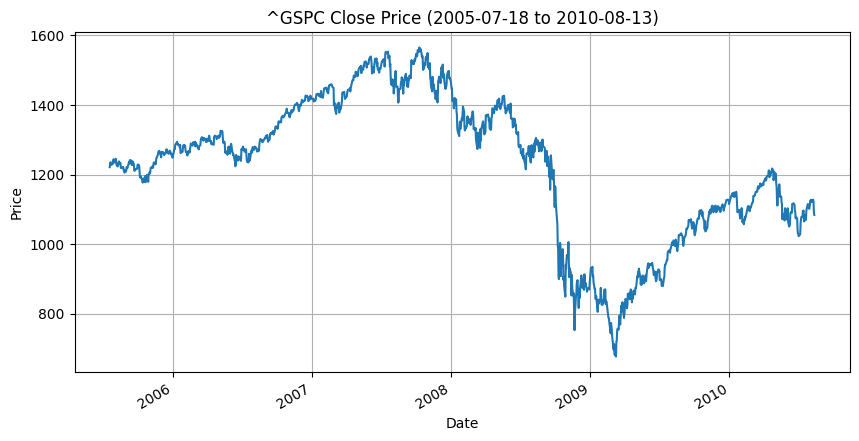

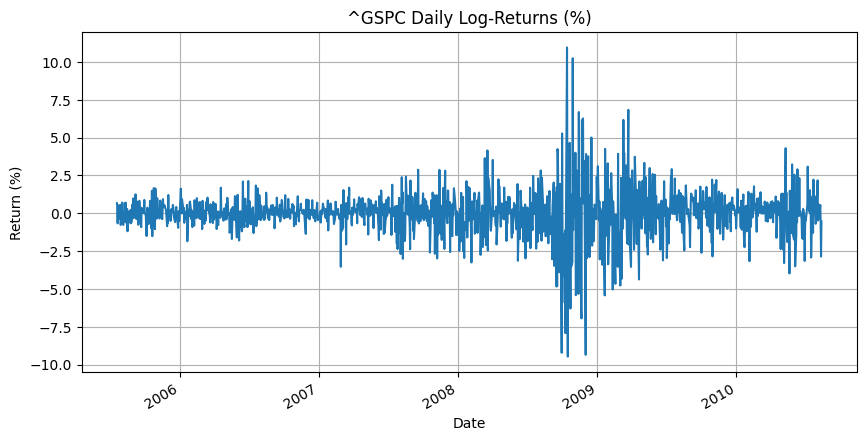

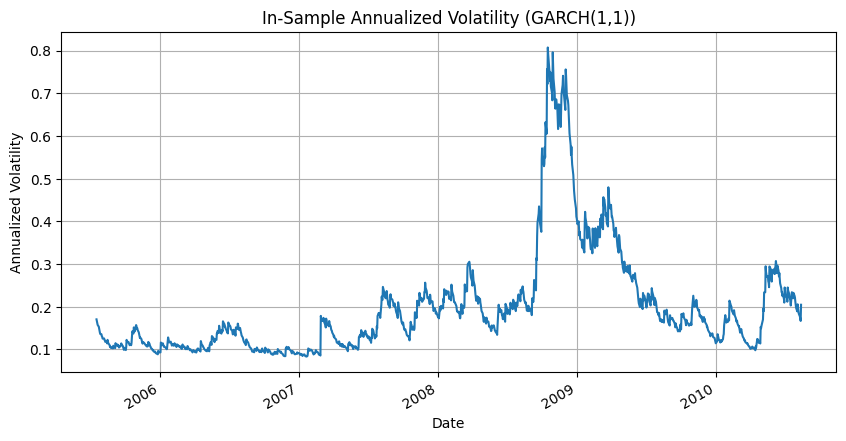

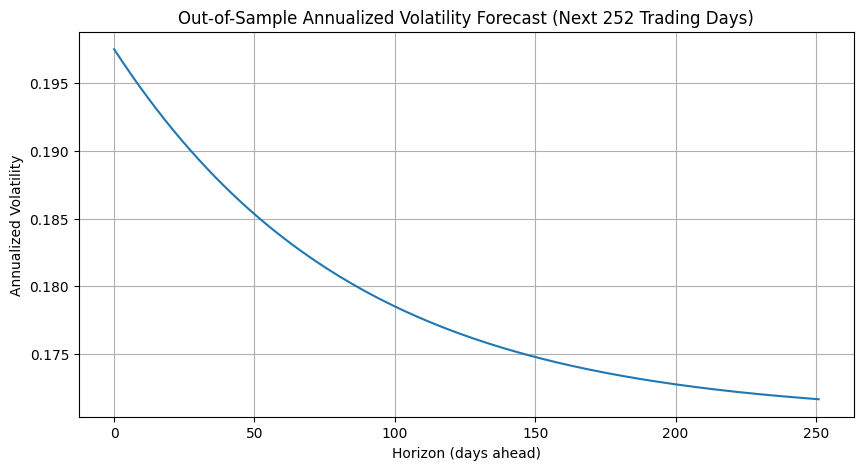

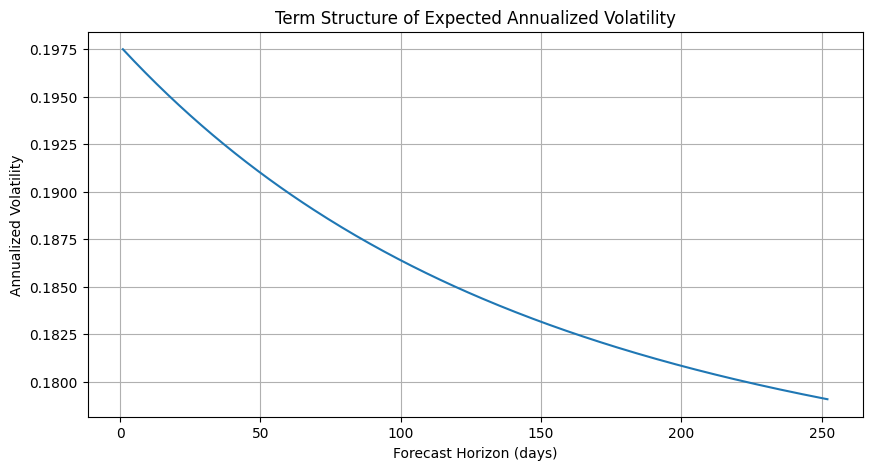

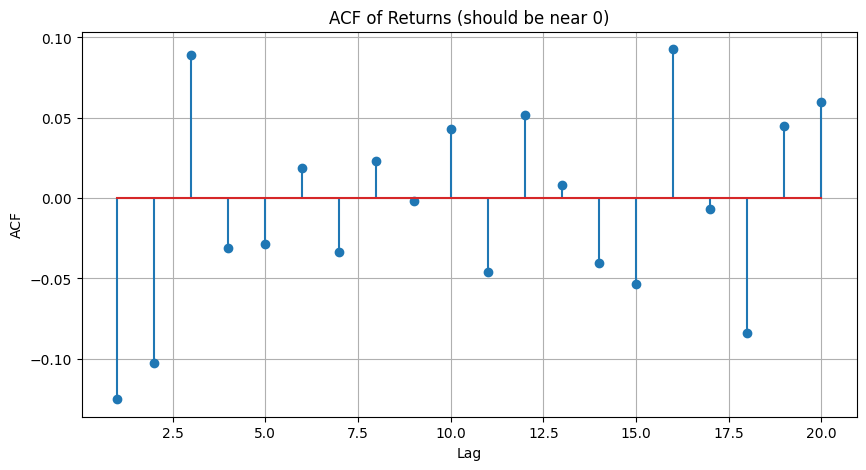

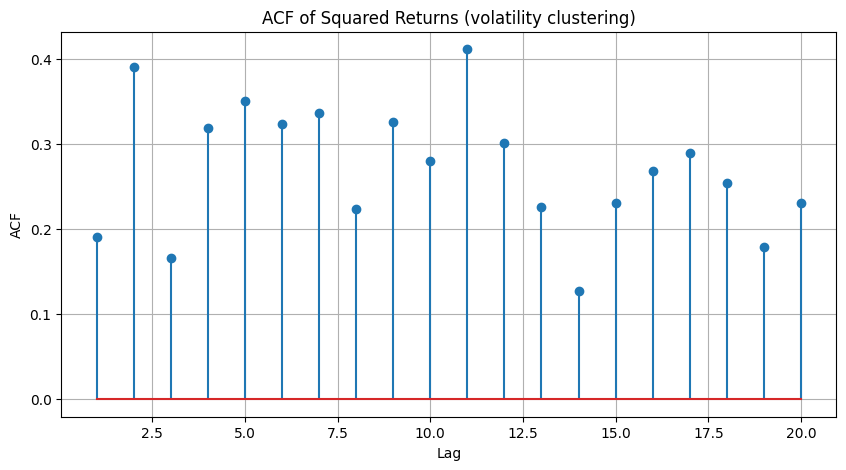


Final parameter estimates:
omega = 0.014463
alpha = 0.079000
beta  = 0.908455
alpha+beta = 0.987455
Half-life (days) ≈ 54.91

First 5 rows of volatility term structure:
   horizon  annualized_vol
0        1        0.197501
1        2        0.197343
2        3        0.197186
3        4        0.197031
4        5        0.196876

Saved: garch_term_structure.csv, garch_insample_annualized_vol.csv


In [13]:
# =========================
# 0. Imports & Settings
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, Dict
from scipy.optimize import minimize

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

# Toggle to use cached CSV instead of yfinance (offline mode)
USE_CSV = False
DATA_CSV = "sp500_prices.csv"  # If USE_CSV=True, path to a CSV with Date, Close

START_DATE = "2005-07-18"
END_DATE   = "2010-08-13"
SYMBOL     = "^GSPC"

# =========================
# 1. Data Loading & Returns
# =========================

def load_prices(symbol: str, start: str, end: str) -> pd.DataFrame:
    """Load daily close prices for symbol between start and end.
    Returns a DataFrame with columns: ['Close'] indexed by Date.
    """
    if USE_CSV:
        df = pd.read_csv(DATA_CSV)
        # Expect columns Date, Close
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values('Date').set_index('Date')
        return df[['Close']].dropna()
    else:
        try:
            import yfinance as yf
            data = yf.download(symbol, start=start, end=end, progress=False)
            # Prefer adjusted close to account for splits/dividends
            col = 'Adj Close' if 'Adj Close' in data.columns else 'Close'
            df = data[[col]].dropna().copy()
            df.index = pd.to_datetime(df.index)
            df = df.sort_index()
            df = df[~df.index.duplicated(keep='last')]
            df.columns = ['Close']  # unify downstream naming
            return df
        except Exception as e:
            raise RuntimeError(
                f"yfinance download failed ({e}). Set USE_CSV=True and provide a CSV."
            )


def compute_log_returns(close: pd.Series) -> pd.Series:
    r = 100 * np.log(close / close.shift(1))  # percentage log return
    return r.dropna()


# =========================
# 2. GARCH(1,1) Likelihood
# =========================
@dataclass
class GARCHParams:
    omega: float
    alpha: float
    beta: float


def garch_ll(params: np.ndarray, eps: np.ndarray) -> float:
    """Negative log-likelihood for Gaussian GARCH(1,1) with zero mean returns.
    eps: return innovations (here, raw returns r_t if mean=0), shape (T,)
    params: [omega, alpha, beta]
    """
    omega, alpha, beta = params

    # Parameter constraints; return large penalty if violated
    if (omega <= 0) or (alpha < 0) or (beta < 0) or (alpha + beta >= 1):
        return 1e12

    T = eps.shape[0]
    # Initialize h_0 as the unconditional variance
    h = np.empty(T)
    h0 = omega / (1.0 - alpha - beta)
    if h0 <= 0:
        return 1e12
    h[0] = h0

    # Recursion
    for t in range(1, T):
        h[t] = omega + alpha * eps[t-1]**2 + beta * h[t-1]
        if h[t] <= 0:
            return 1e12

    # Gaussian log-likelihood sum_t [0.5*(log(2π) + log(h_t) + eps_t^2 / h_t)]
    nll = 0.5 * np.sum(np.log(2*np.pi) + np.log(h) + (eps**2)/h)
    return nll


def fit_garch_mle(eps: np.ndarray, x0: Tuple[float, float, float] = (0.01, 0.05, 0.90)) -> Tuple[GARCHParams, Dict]:
    """Fit GARCH(1,1) via MLE. Returns (params, info).
    x0: starting values for (omega, alpha, beta)
    """
    bounds = [(1e-8, None), (1e-8, 1 - 1e-6), (1e-8, 1 - 1e-6)]  # loose upper bounds; constraint handled in NLL

    def constraint_fun(x):
        # alpha + beta < 1  ->  1 - alpha - beta > 0
        return 1 - x[1] - x[2]

    cons = ({'type': 'ineq', 'fun': constraint_fun},)

    res = minimize(
        fun=garch_ll,
        x0=np.array(x0, dtype=float),
        args=(eps,),
        method='SLSQP',
        bounds=bounds,
        constraints=cons,
        options={'maxiter': 2000, 'ftol': 1e-12, 'disp': False}
    )

    if not res.success:
        print("Warning: Optimization did not fully converge:", res.message)

    omega, alpha, beta = res.x
    params = GARCHParams(omega=float(omega), alpha=float(alpha), beta=float(beta))
    info = {
        'success': res.success,
        'message': res.message,
        'fun': res.fun,
        'nit': res.nit,
        'x': res.x,
        'jac': getattr(res, 'jac', None),
        'hess_inv': getattr(res, 'hess_inv', None)
    }
    return params, info


def infer_variance(eps: np.ndarray, p: GARCHParams) -> np.ndarray:
    """Compute filtered h_t given residuals and fitted parameters."""
    T = eps.shape[0]
    h = np.empty(T)
    h[0] = p.omega / (1 - p.alpha - p.beta)
    for t in range(1, T):
        h[t] = p.omega + p.alpha * eps[t-1]**2 + p.beta * h[t-1]
    return h


# =========================
# 3. Forecasting & Term Structure
# =========================

def garch_forecast(h_last: float, eps_last2: float, p: GARCHParams, horizon: int = 252) -> np.ndarray:
    """Multi-step-ahead forecasts of conditional variance h_{T+k}.
    For k=1: h_{T+1} = omega + alpha * eps_T^2 + beta * h_T
    For k>=2: h_{T+k} = omega + (alpha + beta) * h_{T+k-1} (since E[eps^2] = h)
    Returns array of length `horizon`.
    """
    h_fc = np.empty(horizon)
    # 1-step uses last realized shock
    h_fc[0] = p.omega + p.alpha * eps_last2 + p.beta * h_last
    phi = p.alpha + p.beta
    for k in range(1, horizon):
        h_fc[k] = p.omega + phi * h_fc[k-1]
    return h_fc


def term_structure_annualized_vol(h_fc: np.ndarray, scale_per_year: int = 252) -> pd.DataFrame:
    """Compute term structure of annualized vol for horizons 1..H.
    Annualized vol for horizon k using variance forecasts h_fc[0..k-1]:
        Var_k = average of the k variances (for expected k-step variance)
        Vol_k = sqrt(Var_k * (scale_per_year)) / 100  (since r in %)
    Returns DataFrame with columns: k, ann_vol
    """
    ks = np.arange(1, len(h_fc) + 1)
    avg_var = np.array([np.mean(h_fc[:k]) for k in ks])
    ann_vol = np.sqrt(avg_var * scale_per_year) / 100.0
    return pd.DataFrame({"horizon": ks, "annualized_vol": ann_vol})


# =========================
# 4. Diagnostics
# =========================

def acf(x: np.ndarray, lags: int = 20) -> np.ndarray:
    """Simple (biased) ACF up to `lags` (excluding lag 0)."""
    x = x - np.mean(x)
    denom = np.sum(x**2)
    acfs = []
    for k in range(1, lags+1):
        num = np.sum(x[:-k] * x[k:])
        acfs.append(num / denom)
    return np.array(acfs)


# =========================
# 5. Main Pipeline
# =========================
if __name__ == "__main__":
    # Load prices and returns
    prices = load_prices(SYMBOL, START_DATE, END_DATE)
    r = compute_log_returns(prices['Close'])  # percent log-returns
    eps = r.values  # zero mean assumption

    print("Price date range:", prices.index.min().date(), "to", prices.index.max().date())
    print("Trading days:", len(prices))
    print("Sample size (returns):", len(eps))
    print("Return summary (%):\n", pd.Series(eps).describe())

    # Fit GARCH(1,1)
    theta0 = (0.01, 0.05, 0.90)
    params, info = fit_garch_mle(eps, x0=theta0)
    print("\nMLE Results (GARCH(1,1)):")
    print(params)
    print("Converged:", info['success'], "| message:", info['message'])

    # Filtered variance and in-sample annualized vol
    h = infer_variance(eps, params)
    ann_vol_insample = np.sqrt(h * 252) / 100.0  # because returns in %

    # One-year (252-day) variance forecast path
    h_last = h[-1]
    eps_last2 = eps[-1]**2
    h_fc = garch_forecast(h_last=h_last, eps_last2=eps_last2, p=params, horizon=252)
    term = term_structure_annualized_vol(h_fc, scale_per_year=252)

    # Mean reversion half-life (in days)
    phi = params.alpha + params.beta
    half_life = np.log(0.5) / np.log(phi) if phi < 1 else np.inf
    print(f"\nPersistence (alpha+beta) = {phi:.4f}; Half-life ≈ {half_life:.2f} days")

    # =========================
    # Plots
    # =========================
    # 1) Prices
    prices['Close'].plot(title=f"{SYMBOL} Close Price ({START_DATE} to {END_DATE})")
    plt.xlabel("Date"); plt.ylabel("Price")
    plt.show()

    # 2) Returns
    r.plot(title=f"{SYMBOL} Daily Log-Returns (%)")
    plt.xlabel("Date"); plt.ylabel("Return (%)")
    plt.show()

    # 3) In-sample annualized volatility (sqrt(h_t)*sqrt(252))
    pd.Series(ann_vol_insample, index=r.index).plot(title="In-Sample Annualized Volatility (GARCH(1,1))")
    plt.xlabel("Date"); plt.ylabel("Annualized Volatility")
    plt.show()

    # 4) Forecast path (variance and annualized vol)
    plt.plot(np.sqrt(h_fc*252)/100.0)
    plt.title("Out-of-Sample Annualized Volatility Forecast (Next 252 Trading Days)")
    plt.xlabel("Horizon (days ahead)"); plt.ylabel("Annualized Volatility")
    plt.show()

    # 5) Term structure (1..252 days average variance annualized)
    plt.plot(term['horizon'], term['annualized_vol'])
    plt.title("Term Structure of Expected Annualized Volatility")
    plt.xlabel("Forecast Horizon (days)"); plt.ylabel("Annualized Volatility")
    plt.show()

    # 6) Diagnostics: ACF of returns and squared returns
    acf_r = acf(eps, lags=20)
    acf_r2 = acf(eps**2, lags=20)

    plt.stem(range(1, 21), acf_r) # Removed use_line_collection=True
    plt.title("ACF of Returns (should be near 0)")
    plt.xlabel("Lag"); plt.ylabel("ACF")
    plt.show()

    plt.stem(range(1, 21), acf_r2) # Removed use_line_collection=True
    plt.title("ACF of Squared Returns (volatility clustering)")
    plt.xlabel("Lag"); plt.ylabel("ACF")
    plt.show()

    # =========================
    # 6. Handy outputs
    # =========================
    print("\nFinal parameter estimates:")
    print(f"omega = {params.omega:.6f}")
    print(f"alpha = {params.alpha:.6f}")
    print(f"beta  = {params.beta:.6f}")
    print(f"alpha+beta = {phi:.6f}")
    print(f"Half-life (days) ≈ {half_life:.2f}")

    print("\nFirst 5 rows of volatility term structure:")
    print(term.head())

    # Save key tables (optional)
    term.to_csv("garch_term_structure.csv", index=False)
    pd.DataFrame({"date": r.index, "ann_vol_insample": ann_vol_insample}).to_csv(
        "garch_insample_annualized_vol.csv", index=False
    )
    print("\nSaved: garch_term_structure.csv, garch_insample_annualized_vol.csv")


# =========================
# Tasks — Project Specification Mapping
# =========================

# Utility: ensure data and fit exist (reuses global objects if already created)
# Removed _ensure_data_and_fit() as it was causing variable scope issues.
# Ensure the main block is run first to define necessary variables.


# -------------------------
# Task 1: Parameter Estimation & In-Sample Volatility
# -------------------------
def task1_parameter_estimation_and_vol_plot():
    """Implements Task 1 requirements.
    - Estimates (omega, alpha, beta) via MLE
    - Reports maximum log-likelihood value
    - Computes long-term (unconditional) volatility
    - Plots conditional volatility for 2005-07-18 to 2010-08-13
    """
    # Ensure necessary variables are defined by running the main block first.

    # Parameters & log-likelihood (Gaussian)
    omega, alpha, beta = params.omega, params.alpha, params.beta
    phi = alpha + beta
    nll = garch_ll(np.array([omega, alpha, beta]), eps)
    loglike = -nll

    # Long-term variance and volatility
    var_long = omega / (1 - phi)
    vol_long_daily = np.sqrt(var_long) / 100.0  # because eps is in percent
    vol_long_annual = vol_long_daily * np.sqrt(252)

    print("TASK 1 starts here ...")
    print("="*50)
    print(f"omega = {omega:.8f}, alpha = {alpha:.8f}, beta = {beta:.8f}")
    print(f"alpha+beta (persistence) = {phi:.6f}")
    print(f"Max log-likelihood (Gaussian) = {loglike:.3f}")
    print(f"Unconditional variance = {var_long:.6f} (%^2)")
    print(f"Unconditional daily vol = {vol_long_daily:.4f} (decimal)")
    print(f"Unconditional annual vol = {vol_long_annual:.4f} (decimal)")

    # In-sample annualized volatility plot
    ann_vol_insample = np.sqrt(h * 252) / 100.0  # decimal
    pd.Series(ann_vol_insample, index=r.index).plot(
        title="Task 1 — In-Sample Annualized Volatility (GARCH(1,1))"
    )
    plt.xlabel("Date"); plt.ylabel("Annualized Vol (decimal)")
    plt.show()


# -------------------------
# Task 2: Forecasting & Term Structure
# -------------------------
from datetime import datetime

def _expected_variance_path(h_T: float, p: GARCHParams, H: int) -> np.ndarray:
    """E[h_{T+k}] = V_L + (alpha+beta)^k * (h_T - V_L), k=1..H"""
    phi = p.alpha + p.beta
    V_L = p.omega / (1 - phi)
    ks = np.arange(1, H+1)
    return V_L + (phi**ks) * (h_T - V_L)


def task2_forecast_and_term_structure():
    """Task 2 Parts A & B.
    Part A: Build an out-of-sample expected variance path from 2010-08-14 to 2015-08-08
            using business days, and plot annualized daily vol.
    Part B: Compute annualized vol term structure at horizons [10, 30, 50, 100, 500].
    """
    # Ensure necessary variables are defined by running the main block first.

    # Part A — Out-of-sample dates (business days)
    fc_start = pd.Timestamp('2010-08-14')
    fc_end   = pd.Timestamp('2015-08-08')
    dates_fc = pd.bdate_range(fc_start, fc_end)  # business days within inclusive bounds
    H = len(dates_fc)

    h_T = h[-1]
    h_exp_path = _expected_variance_path(h_T, params, H)

    # Annualized daily volatility (decimal)
    vol_ann_path = np.sqrt(h_exp_path * 252) / 100.0

    pd.Series(vol_ann_path, index=dates_fc).plot(
        title="Task 2A — Out-of-Sample Annualized Volatility Forecast (Expected)"
    )
    plt.xlabel("Date"); plt.ylabel("Annualized Vol (decimal)")
    plt.show()

    # Part B — Term structure at specified horizons using average expected variance
    horizons = np.array([10, 30, 50, 100, 500])
    term_rows = []
    for k in horizons:
        k = int(k)
        avg_var_k = np.mean(h_exp_path[:k])  # average expected daily variance over first k days
        vol_daily_k = np.sqrt(avg_var_k) / 100.0
        vol_ann_k = vol_daily_k * np.sqrt(252)
        term_rows.append({"horizon": k, "daily_vol": vol_daily_k, "annualized_vol": vol_ann_k})

    term_df = pd.DataFrame(term_rows).set_index("horizon")
    print("Task 2B — Volatility Term Structure (expected):")
    print(term_df)

    plt.plot(term_df.index.values, term_df["annualized_vol"].values)
    plt.title("Task 2B — Volatility Term Structure (Annualized)")
    plt.xlabel("Horizon (trading days)")
    plt.ylabel("Annualized Vol (decimal)")
    plt.show()


# Uncomment to run tasks immediately when executing this script:
# task1_parameter_estimation_and_vol_plot()
# task2_forecast_and_term_structure()